### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 5th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy
from scipy.stats import norm,uniform
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import corner
import acor

import dynesty
from dynesty import plotting as dyplot

%matplotlib inline
%config InlineBackend.figure_format='retina'

Optional mpi4py package is not installed.  MPI support is not available.


### Part 1

In [2]:
datadir = '../../../homeworks/hw_data/'
rawdata = np.load(datadir+'hw5_data_1.npy')

timeData = rawdata[:,0]
fluxData = rawdata[:,1]
sigData = rawdata[:,2]

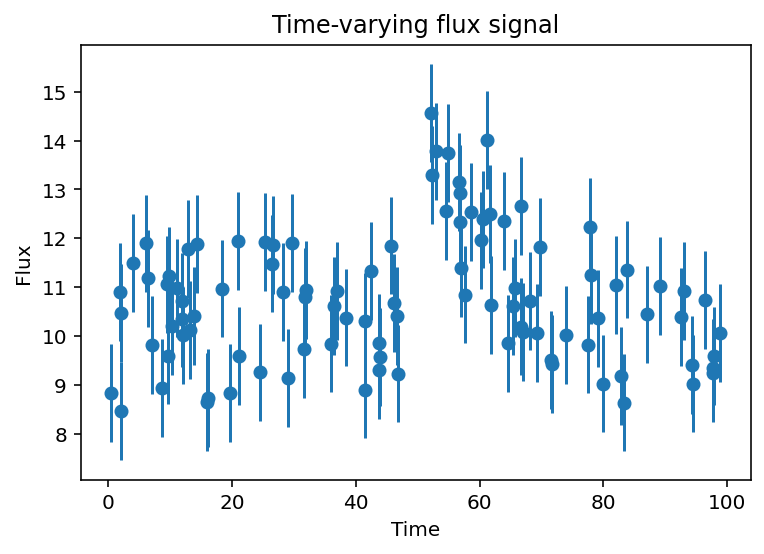

In [3]:
plt.title('Time-varying flux signal')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.errorbar(timeData,fluxData,yerr=sigData,fmt='o')
plt.show()

### Part 2

In [4]:
#pars need to be in [b,A,t0,alpha] order
def model(t,pars):
    y = np.ones(len(t))*pars[0]
    
    #Take piecewise bit (tcut is all indexes where t>t0)
    tcut = np.argwhere(t>=pars[2])[:,0]

    y[tcut] += pars[1]*np.exp(-pars[3]*(t[tcut]-pars[2]))
        
    return y
    

#pars need to be in [b,A,t0,alpha] order
def lnLikelihood(pars,t=timeData,y=fluxData,sig=sigData,addConst=False):
    #used for evidence if needed
    if addConst:
        const = np.log(np.sqrt(1/(2*np.pi*sig**2)))
    else:
        const=0

    return const-np.sum((y-model(t,pars))**2/(2*sig**2))

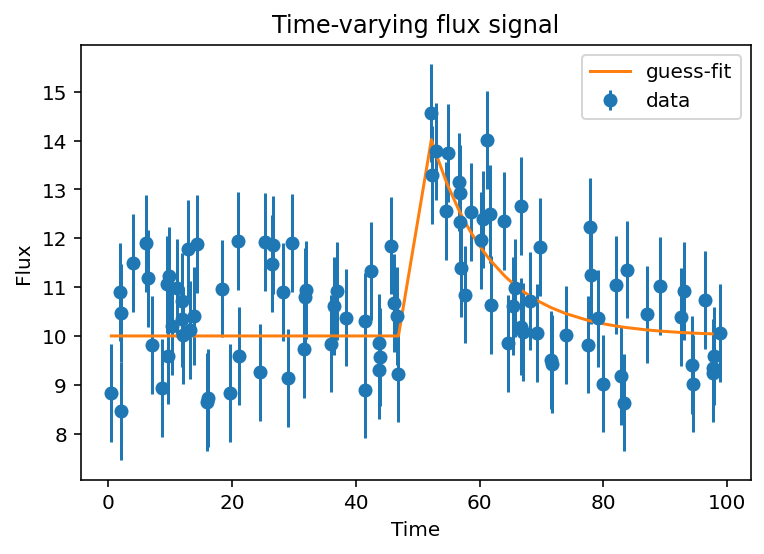

Log likelihood for guess: -51.488086205373705


In [5]:
#Check to make sure the model works
guess = [10,5,50,0.1]
plt.title('Time-varying flux signal')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.errorbar(timeData,fluxData,yerr=sigData,fmt='o',label='data')
plt.plot(timeData,model(timeData,guess),label='guess-fit')
plt.legend()
plt.show()
print(f'Log likelihood for guess: {lnLikelihood(guess)}')


### Part 3

#### Using PTMCMC

In [6]:
#setup priors
#𝑏 ∈ Uniform[0,50] , 𝐴 ∈ Uniform[0,50], 𝑡0 ∈ Uniform[0,100], and ln𝛼 ∈ Uniform[−5,5].
priorb = uniform(loc=0,scale=50)
priorA = uniform(loc=0,scale=50)
priorT0 = uniform(loc=0,scale=100)
priorLogA = uniform(loc=-5,scale=10)

#pars need to be in [b,A,t0,alpha] order
def prior(pars):
    #Prior is just multiplication of all individual priors
    return priorb.pdf(pars[0])*priorA.pdf(pars[1])*priorT0.pdf(pars[2])*priorLogA.pdf(np.log(pars[3]))

def logPrior(pars):
    return np.log(prior(pars))

In [7]:
# dimension of parameter space
ndim = 4

# initial jump covariance matrix, just guess. This will get automatically fixed
cov = np.diag(np.ones(ndim) * 0.01**2)

#Random start (draw from prior)
parStart = np.array([priorb.rvs(1)[0],priorA.rvs(1)[0],priorT0.rvs(1)[0],np.exp(priorLogA.rvs(1)[0])])

# intialize sampler
sampler = ptmcmc(ndim, lnLikelihood, logPrior, cov, 
                 outDir='./ptmcmc_4par', resume=False)

In [8]:
#Sample!
sampler.sample(parStart,int(1e6))

Finished 0.20 percent in 0.513587 s Acceptance rate = 0.5595

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_10589/2244290564.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(prior(pars))


Finished 0.30 percent in 0.773635 s Acceptance rate = 0.434667

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_10589/2244290564.py:10: RuntimeWarning: invalid value encountered in log
  return priorb.pdf(pars[0])*priorA.pdf(pars[1])*priorT0.pdf(pars[2])*priorLogA.pdf(np.log(pars[3]))
/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_10589/3621416852.py:8: RuntimeWarning: overflow encountered in exp
  y[tcut] += pars[1]*np.exp(-pars[3]*(t[tcut]-pars[2]))
/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_10589/3621416852.py:21: RuntimeWarning: overflow encountered in square
  return const-np.sum((y-model(t,pars))**2/(2*sig**2))


Finished 0.60 percent in 1.536575 s Acceptance rate = 0.268167

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_10589/3621416852.py:8: RuntimeWarning: overflow encountered in multiply
  y[tcut] += pars[1]*np.exp(-pars[3]*(t[tcut]-pars[2]))


Finished 1.00 percent in 2.538032 s Acceptance rate = 0.189143Adding DE jump with weight 20
Finished 99.90 percent in 309.036081 s Acceptance rate = 0.135476
Run Complete


### Part 4

#### NOTE:
I did not include the chain file in the upload. It wasn't huge (14mb), but bigger than git should be keeping track of. If you want this file, I can easily add it to git. Just ask!

In [9]:
# Load in the chain
chain = np.loadtxt('./ptmcmc_4par/chain_1.txt')
print(chain.shape)
#ORDER OF ELEMENTS:
# [b,A,t0,alpha
# Unnormalized log posterior probability density values,
# Log likelihood,
# Chain acceptance rate for proposed points,
# Inter-chain acceptance rate for parallel tempering temperature swaps]

(99900, 8)


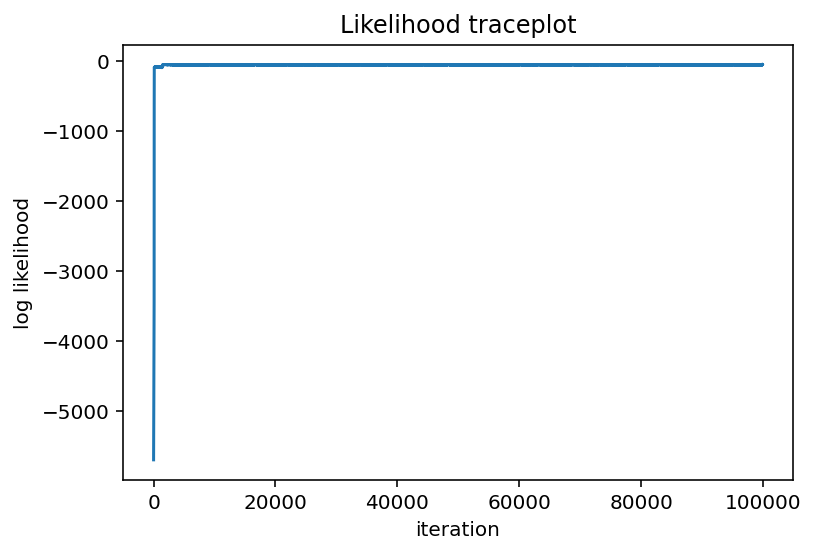

In [10]:
#Plot the likelihood to find a burn in
plt.plot(chain[:,-3])
plt.title('Likelihood traceplot')
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.show()

Autocorrelation length: 10


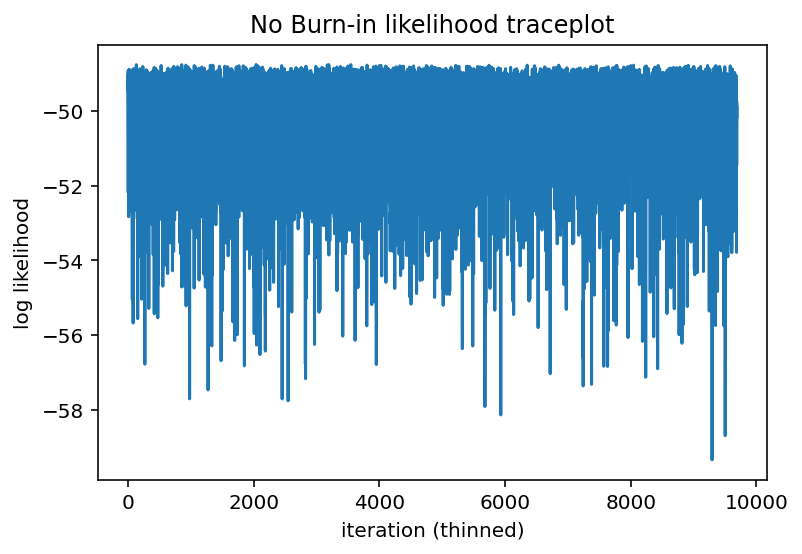

In [11]:
burn = 3000
aLength = acor.acor(chain[burn:,-3])[0]
aLength = int(aLength)+1
print(f'Autocorrelation length: {aLength}')

plt.plot(chain[burn::aLength,-3])
plt.title('No Burn-in likelihood traceplot')
plt.xlabel('iteration (thinned)')
plt.ylabel('log likelihood')
plt.show()

In [12]:
#Get only the burned-in, thinned chain
subChain = chain[burn::aLength]

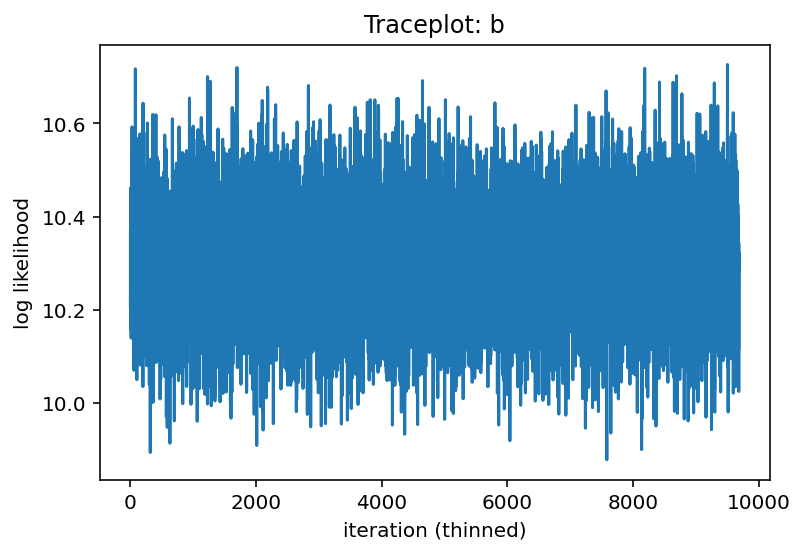

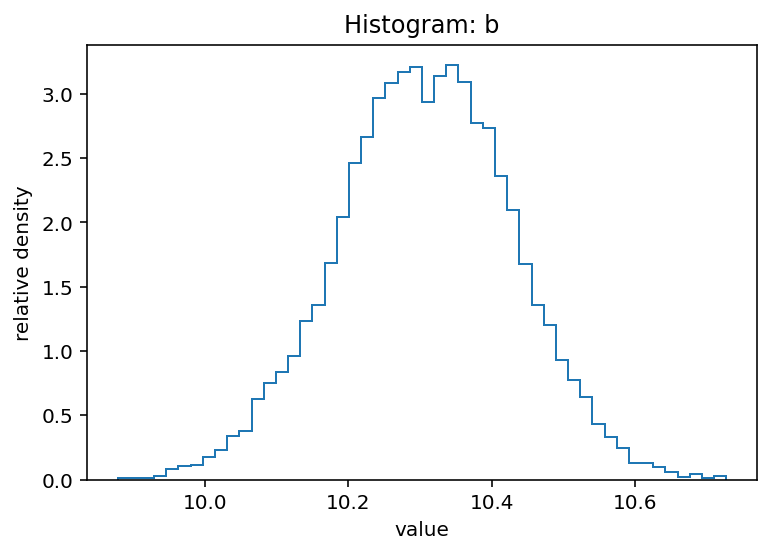

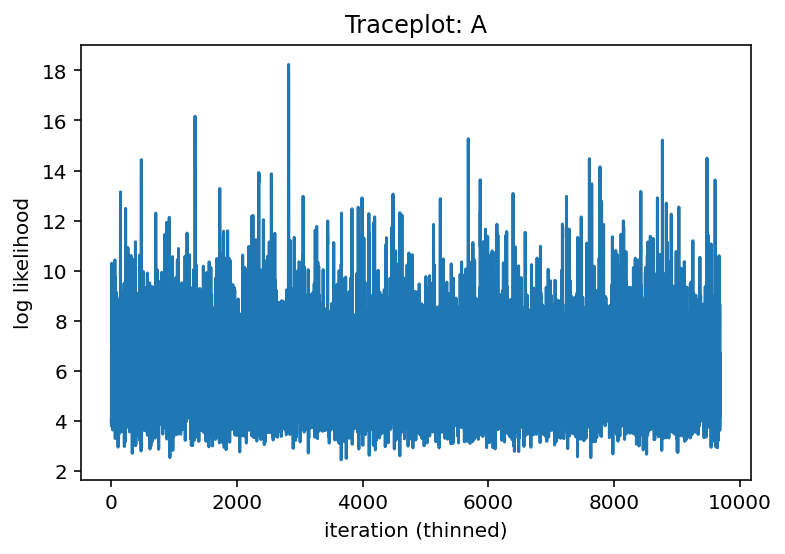

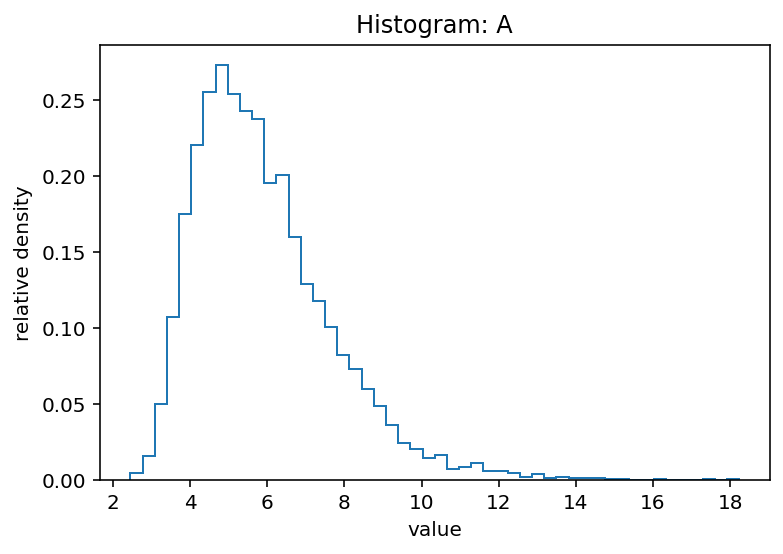

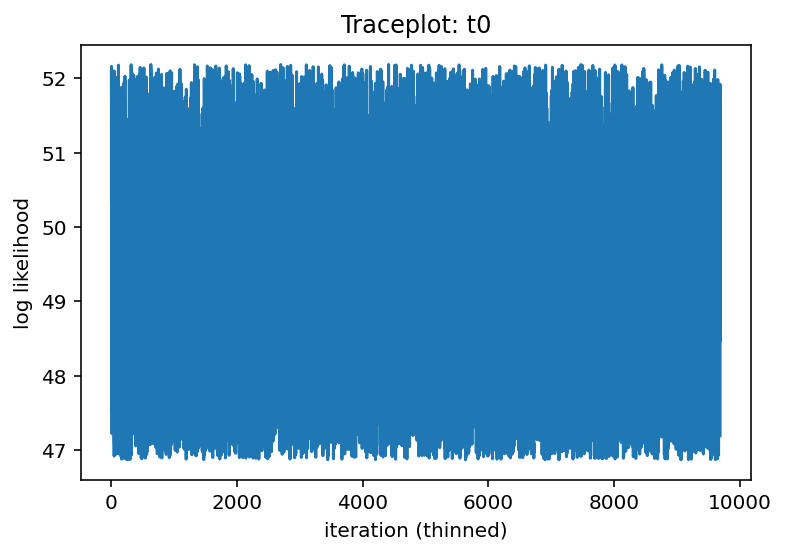

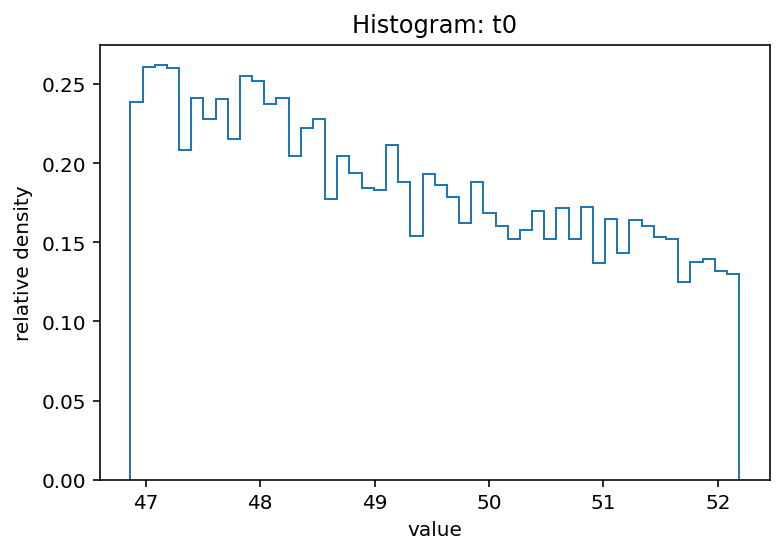

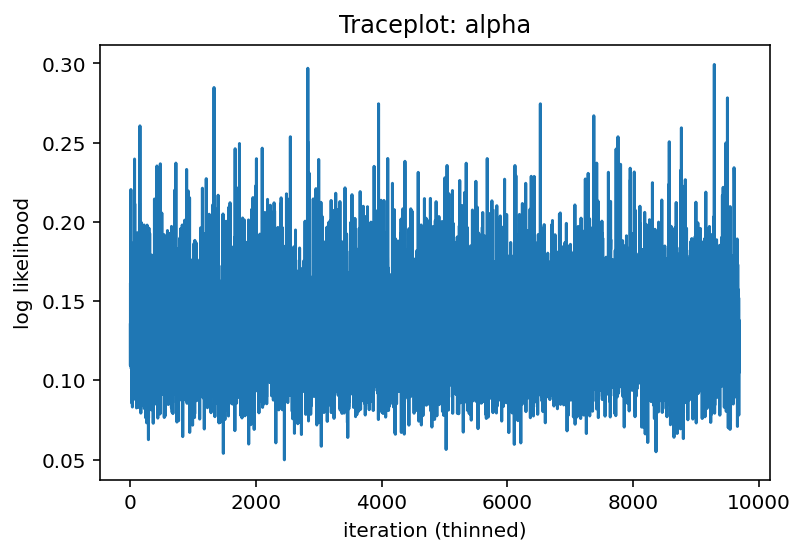

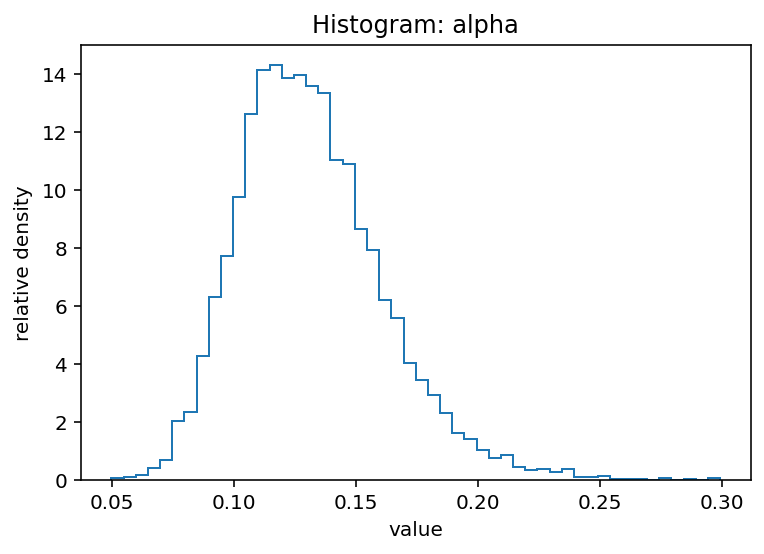

In [13]:
for i,n in enumerate(['b','A','t0','alpha']):
    plt.plot(subChain[:,i])
    plt.title(f'Traceplot: {n}')
    plt.xlabel('iteration (thinned)')
    plt.ylabel('log likelihood')
    plt.show()
    
    plt.hist(subChain[:,i],bins=50,density=True,histtype='step')
    plt.title(f'Histogram: {n}')
    plt.xlabel('value')
    plt.ylabel('relative density')
    plt.show()

### Part 5

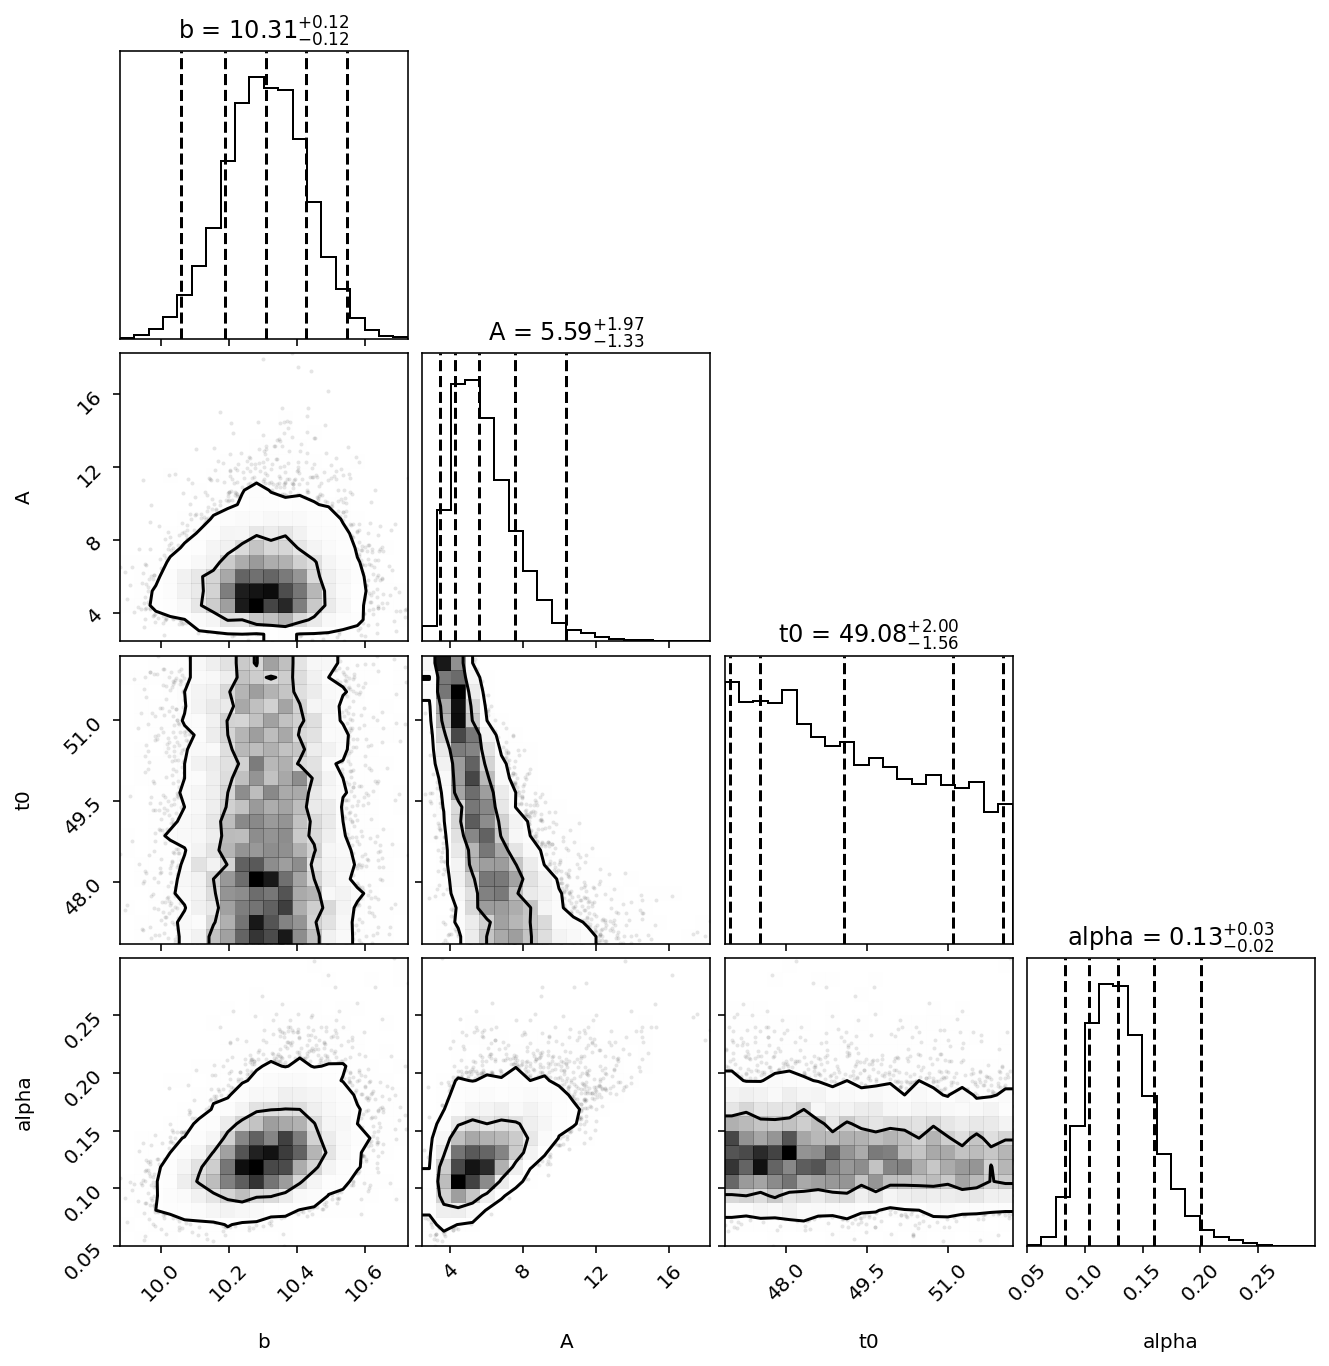

In [14]:
#Use corner!
corner.corner(subChain[:,:-4],levels=[0.68,0.95],quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
              labels=['b','A','t0','alpha'],titles=['b','A','t0','alpha'],show_titles=True)
plt.show()

### Part 6

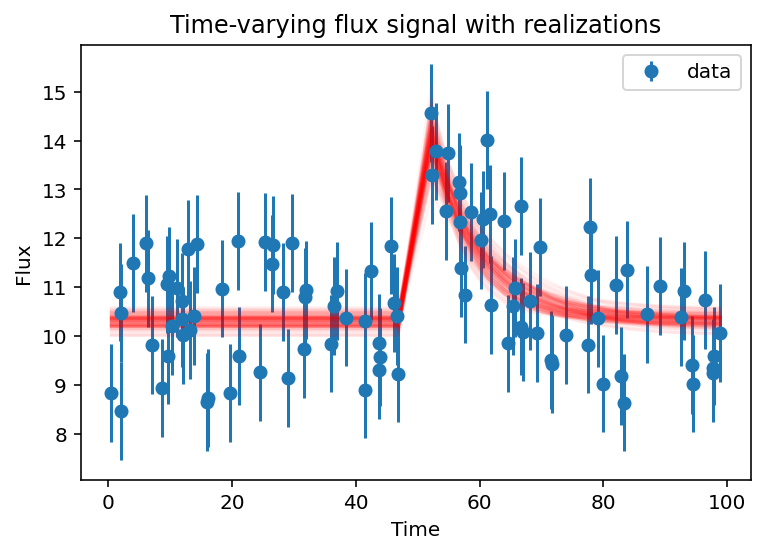

In [15]:
#Get n random samples from chain and plot
nplots = 100
randN = np.array(np.random.random(nplots)*len(subChain),dtype=int)

plt.errorbar(timeData,fluxData,yerr=sigData,fmt='o',label='data')
for r in randN:
    plt.plot(timeData,model(timeData,subChain[r]),'r-',alpha=0.05,)

plt.title('Time-varying flux signal with realizations')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

### Part 7

---

Model 1:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

---

Model 2:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

---

In [16]:
#pars need to be in [b,A,t0,alpha] order
def model_1(t,pars):
    y = np.ones(len(t))*pars[0]
    
    #Take piecewise bit
    tcut = np.argwhere(t>=pars[2])[:,0]

    y[tcut] += pars[1]*np.exp(-pars[3]*(t[tcut]-pars[2]))
        
    return y

#pars need to be in [b,A,t0,sigma] order 
def model_2(t,pars):
    return pars[0] + pars[1]*np.exp(-(t-pars[2])**2/(2*pars[3]**2))
    

#pars need to be in [b,A,t0,alpha] or [b,A,t0,sigma] order
def lnLikelihood(pars,model=model_1,t=timeData,y=fluxData,sig=sigData,addConst=True):
    if addConst:
        const = np.sum(np.log(np.sqrt(1/(2*np.pi*sig**2))))
    else:
        const=0

    return const-np.sum((y-model(t,pars))**2/(2*sig**2))

In [17]:
#U transforms
#[b,A,t0,alpha]
def model_1_transform(u):
    utra = np.zeros(4)
    utra[0] = u[0]*(50-0)+0
    utra[1] = u[1]*(50-0)+0
    utra[2] = u[2]*(100-0)+0
    utra[3] = np.exp(u[3]*(5+5)-5)
    return utra

#[b,A,t0,sigma]
def model_2_transform(u):
    utra = np.zeros(4)
    utra[0] = u[0]*(50-0)+0
    utra[1] = u[1]*(50-0)+0
    utra[2] = u[2]*(100-0)+0
    utra[3] = np.exp(u[3]*(2+2)-2)
    return utra

In [18]:
#Check to make sure transforms work
print(model_1_transform([0,0,0,0]))
print(model_1_transform([1,1,1,1]))

print(model_2_transform([0,0,0,0]))
print(model_2_transform([1,1,1,1]))

[0.         0.         0.         0.00673795]
[ 50.         50.        100.        148.4131591]
[0.         0.         0.         0.13533528]
[ 50.         50.        100.          7.3890561]


In [19]:
ndim = 4 #Both models use 4 parameters
#Use static nested sampling (more accurate evidence)

print('Starting run on model 1')
model_1_sampler = dynesty.NestedSampler(lnLikelihood, model_1_transform, ndim, logl_args=[model_1])
model_1_sampler.run_nested()
model_1_results = model_1_sampler.results


print('Starting run on model 2')
model_2_sampler = dynesty.NestedSampler(lnLikelihood, model_2_transform, ndim, logl_args=[model_2])
model_2_sampler.run_nested()
model_2_results = model_2_sampler.results

iter: 391 | bound: 0 | nc: 1 | ncall: 1097 | eff(%): 35.643 | loglstar:   -inf < -11045.889 <    inf | logz: -11053.578 +/-  0.175 | dlogz: 10901.585 >  0.509                                        

Starting run on model 1


iter: 202 | bound: 0 | nc: 1 | ncall: 747 | eff(%): 27.041 | loglstar:   -inf < -33433.852 <    inf | logz: -33441.163 +/-  0.171 | dlogz: 33515.287 >  0.509                                         

Starting run on model 2


iter: 1314 | bound: 0 | nc: 14 | ncall: 6737 | eff(%): 19.504 | loglstar:   -inf < -796.100 <    inf | logz: -805.564 +/-  0.192 | dlogz: 629.414 >  0.509                                            IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iter: 7536 | bound: 32 | nc: 2 | ncall: 41778 | eff(%): 18.038 | loglstar:   -inf < -145.899 <    inf | logz: -160.124 +/-  0.227 | dlogz:  1.098 >  0.509                                            IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/s

Model 1 corner plot


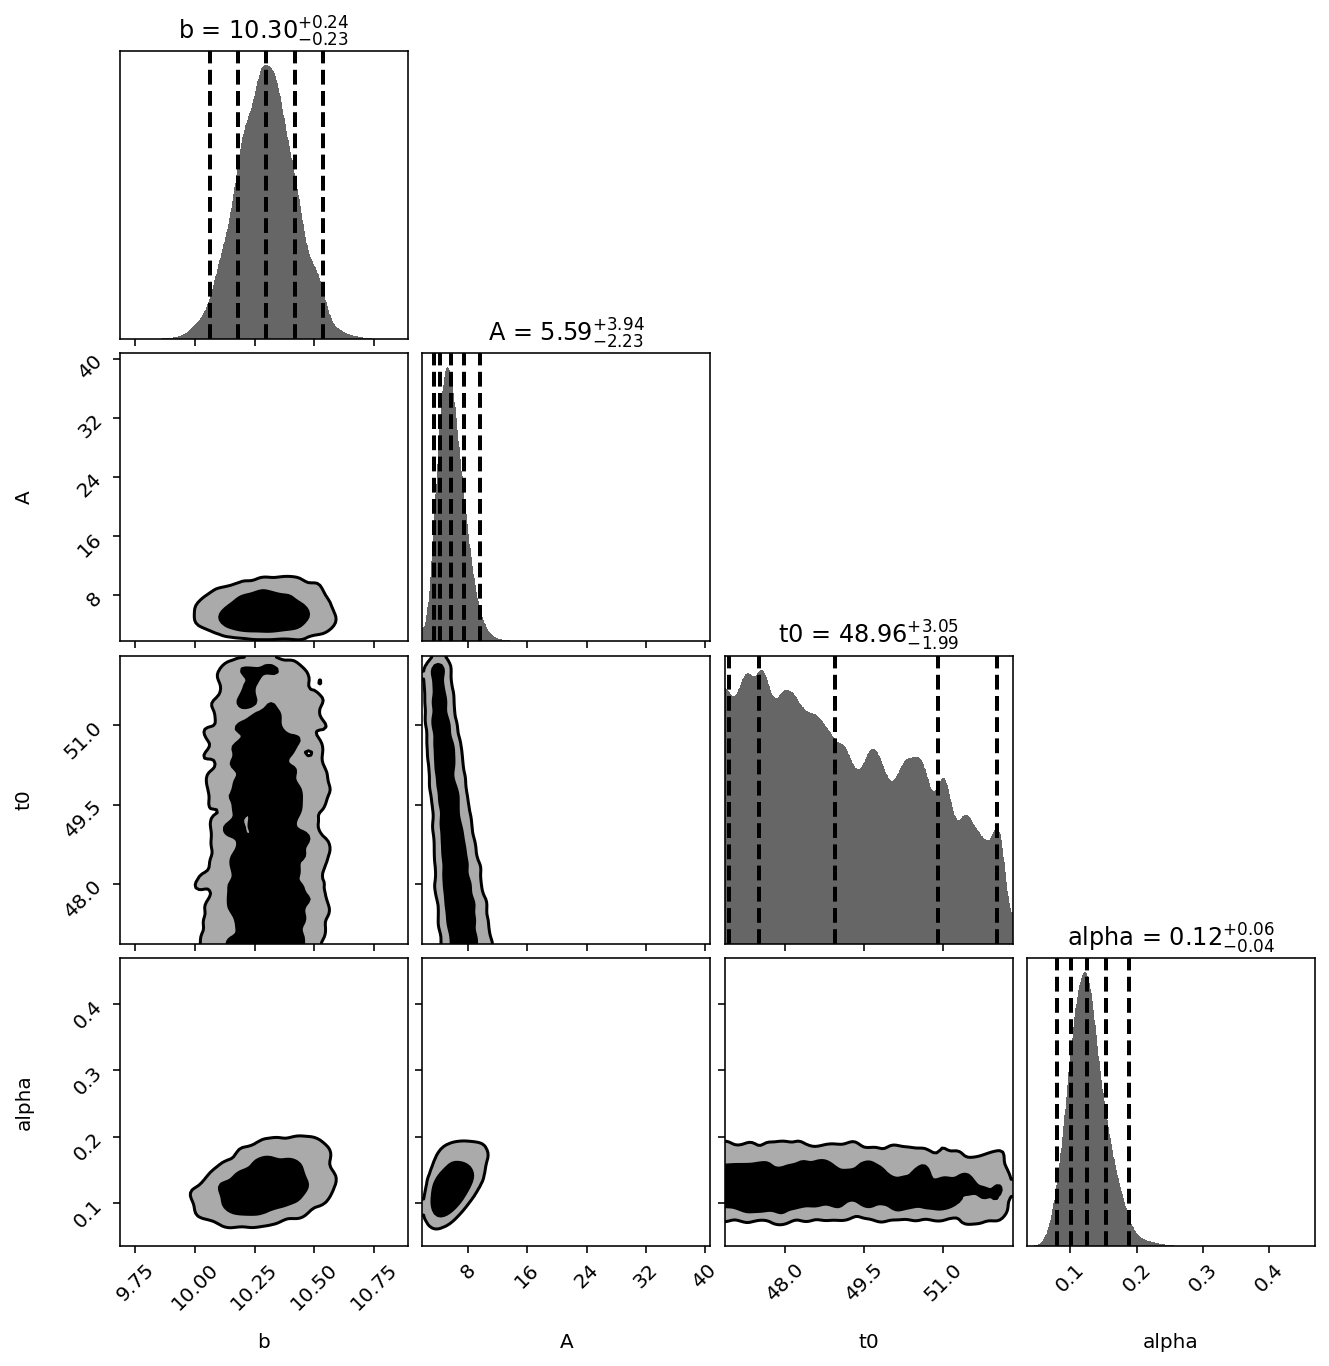

Model 2 corner plot


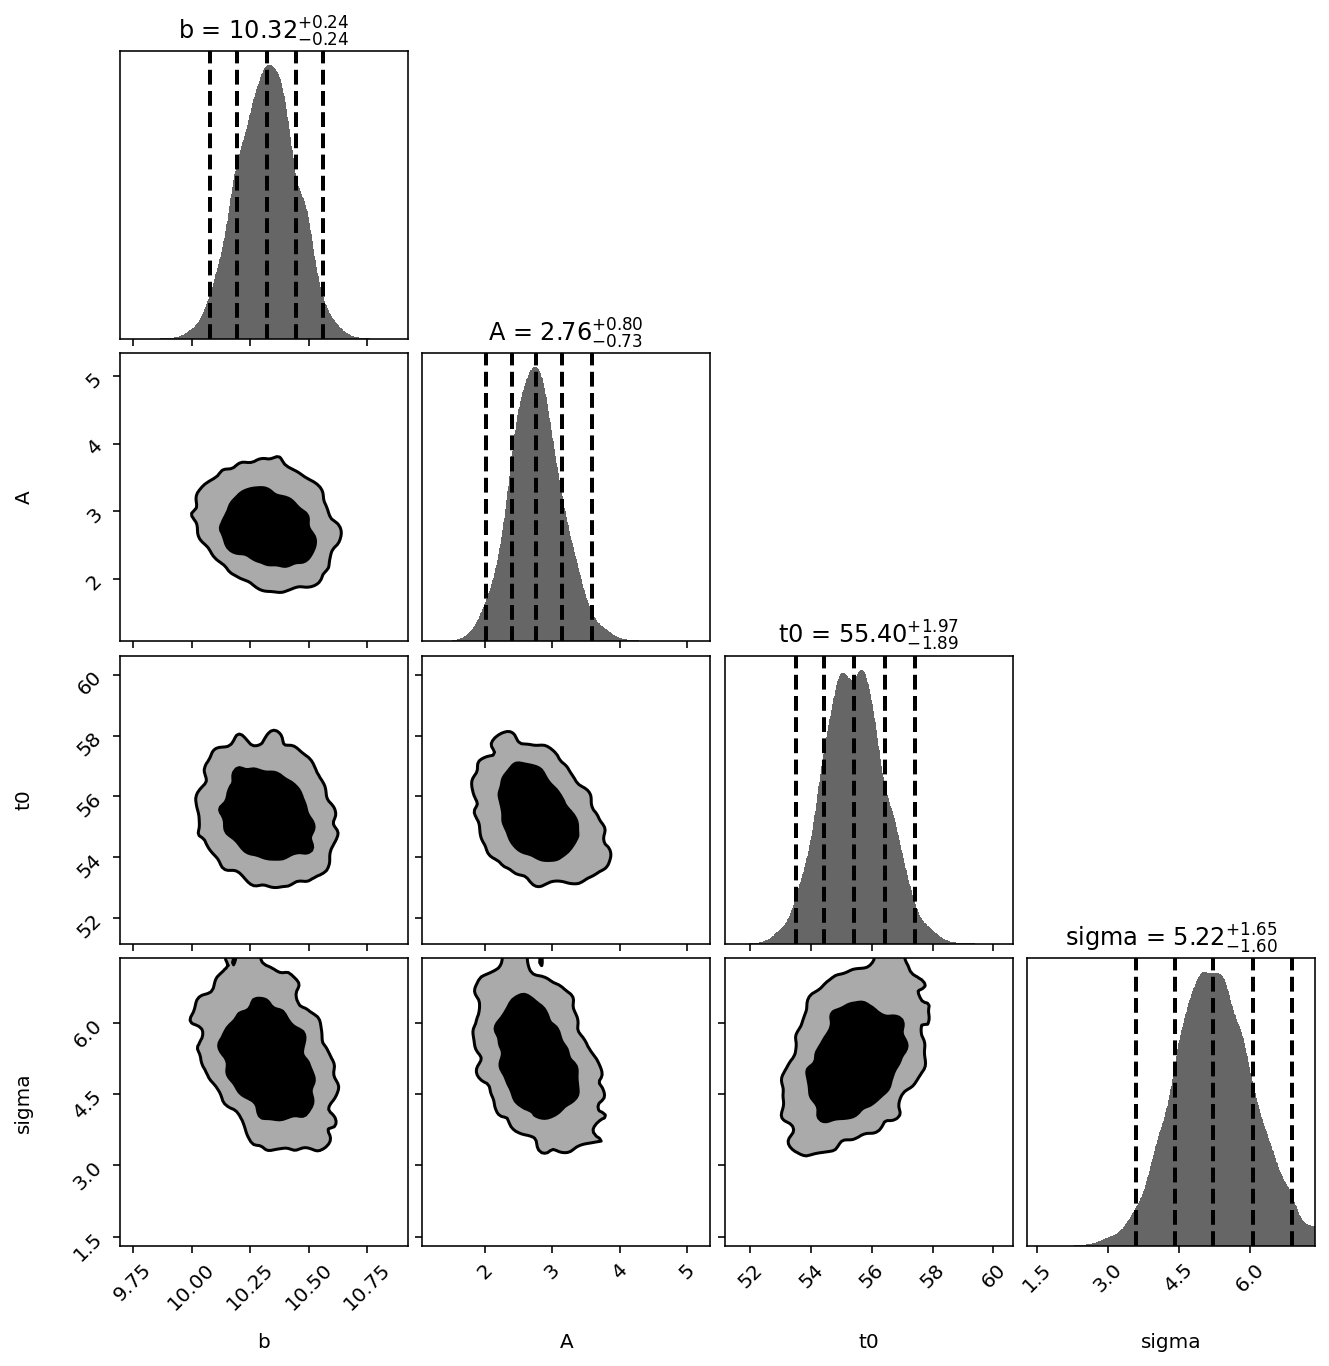

In [20]:
print('Model 1 corner plot')
cfig, caxes = dyplot.cornerplot(model_1_results,quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
                               quantiles_2d=[0.68,0.95],show_titles=True,labels=['b','A','t0','alpha'])
plt.show()

print('Model 2 corner plot')
cfig, caxes = dyplot.cornerplot(model_2_results,quantiles=np.array([-0.477,-0.34,0,0.34,0.477])+0.5,
                               quantiles_2d=[0.68,0.95],show_titles=True,labels=['b','A','t0','sigma'])
plt.show()

In [21]:
model_1_logz = model_1_results['logz'][-1] #Returns evidence for each iteration, just go to end!
model_2_logz = model_2_results['logz'][-1]
dif_logz = model_1_logz-model_2_logz

print(f'Bayesian evidence model 1: {np.exp(model_1_logz)}')
print(f'Bayesian evidence model 2: {np.exp(model_2_logz)}')
print(f'Bayes factor (model_1/model_2): {np.exp(dif_logz)}')

Bayesian evidence model 1: 4.694310842883e-68
Bayesian evidence model 2: 5.1449872127679185e-70
Bayes factor (model_1/model_2): 91.24047638512084


There is very strong evidence that model 1 describes the data better than the new model 2.